In [1]:
pip install smopy 

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\kogan\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\kogan\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\kogan\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install matplotlib

You should consider upgrading via the 'c:\Users\kogan\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [5]:
import cv2

In [6]:
import numpy as np

In [7]:
import matplotlib.pyplot as plt

In [8]:
from matplotlib import cm

In [9]:
import OpenStreetMap 

In [10]:
import OpenWeather

In [11]:
import Simulation

In [12]:
import eel

In [13]:
import json

In [14]:
@eel.expose   # JavaScriptから呼び出したいPython関数の前にこれを記述
def main_simulation():
    # 表示地点の緯度経度 
    # Vue.jsからポストされた任意の地点を設定できるようにすること

    lat = 36.147			
    lon = 139.388

    # Map基点(lat,lon)から終点までの距離（緯度経度）
    angle = 0.00001

    # -------- OpenWeatherMapから風データを取得する(OpenWeather.py) --------
    # 自アカウントのAPIKey
    appid = 'f62cd99ae3ad4f54c119ca6464485f46'
    # 明日以降の天気情報を取得するURL
    forecast_url = 'http://api.openweathermap.org/data/2.5/forecast'

    wind_speed, wind_deg = OpenWeather.forecast(lat, lon, appid, forecast_url)

    # -------- 地図画像の取得と建築物地図の作成(OpenStreetMap.py) --------
    fig = plt.figure(figsize=(11, 11), dpi=300)

    ratio = 16  # 16
    nx = int(768/ratio)
    ny = int(768/ratio)
    
    myLat = 36.147
    myLon = 139.388

    # 解像度違いの地図画像
    mapImg, lowImg  = OpenStreetMap.getMapFromOSM(myLat, myLon, nx, ny, angle)  
    # 解像度違いのマスク（建物配置）画像
    lowImg, lowMask = OpenStreetMap.getMaskFromMap(lowImg) 
    # 高解像度の地図画像を使い、流体粒子表示用の画像を生成・保存
    negaMap = 255 - mapImg

    plt.imshow(mapImg)
    #plt.imshow(lowMask)
    cv2.imwrite('mapimg.png', mapImg)
    cv2.imwrite('lowImg.png', lowImg)
    cv2.imwrite('lowMask.png', lowMask)
    cv2.imwrite('negaMap.png', negaMap)

    # -------- 流体計算を行う(Simulation.py) --------
    u, v, velocity = Simulation.doSimulation(nx, ny, wind_speed, wind_deg, lowMask, 'withOutUVMap')
 
    # -------- 風速ベクトル図を2次元マップ上に可視化する --------
    fig = plt.figure(figsize=(11, 7), dpi=300)
    plt.imshow(mapImg)
    plotX, plotY = np.meshgrid(np.linspace(0, nx*ratio, nx), np.linspace(0, ny*ratio, ny)) 
            # np.linspace：等差数列を生成 np.linspace(最初の値、最後の値、要素数) 

    plt.contourf(plotX, plotY, velocity, alpha=0.2, cmap=cm.jet)
    plt.colorbar()
    plt.quiver(plotX, plotY, u, v)
    #plt.streamplot(plotX, plotY, u, -v)
    plt.xlabel('X')
    plt.ylabel('Y')
    #print(plotY)
    #print(np.amax(u),np.amax(v))
    #print(velocity)

    plt.savefig('figure1.png')

    # -------- Cesiumでベクトル図を表示できるよう、風速u,vを始点・終点座標に変換する --------
    # 指定した緯度経度とズーム率から、その点を含んだ地図タイル（中心に配置される）の座標を取得する
    x, y = OpenStreetMap.get_tile_num(myLat, myLon, 19)

    print('中心のタイル地図のタイル座標=',x,y) # 中心のタイル地図のタイル座標は、タイル地図一枚ごとに与えられる）

    # 9枚のタイル地図のうち、中心タイルの左上のタイル地図の、一番左上端の緯度経度を取得する
    left_bottom0a, left_bottom1a, right_top0a, right_top1a = OpenStreetMap.get_tile_bbox(19, x - 1, y - 1)
    newLat_lefttop = right_top1a    # 左上端緯度
    newLon_lefttop = left_bottom0a  # 左上端経度

    # 9枚のタイル地図のうち、中心タイルの右下のタイル地図の、一番右下端の緯度経度を取得する
    left_bottom0b, left_bottom1b, right_top0b, right_top1b = OpenStreetMap.get_tile_bbox(19, x + 1, y + 1)
    newLat_rightbottom = left_bottom1b  # 右下端緯度
    newLon_rightbottom = right_top0b    # 右下端緯度

    print('画像一番左上の緯度経度=',newLat_lefttop, newLon_lefttop)
    print('画像一番右下の緯度経度=',newLat_rightbottom, newLon_rightbottom)

    # メッシュ座標値を緯度経度に変換する  
    plot_lon_x, plot_lat_y = np.meshgrid(np.linspace(newLon_lefttop, newLon_rightbottom, nx), np.linspace(newLat_lefttop, newLat_rightbottom,  ny))

    # 風速u,vを座標値に変換する　（1メッシュのx方向の長さ,y方向の長さをそれぞれ10m/sと仮定し、10m/sからのu,vの比率を計算して座標値に変換する）
    max_u = 5.0   # 1メッシュ（x方向）の長さを10m/sとする
    max_v = 5.0   # 1メッシュ（y方向）の長さを10m/sとする

    def calc_lon_u(x):
        # メッシュサイズからx方向風速を緯度経度（相対座標）に変換
        return ((x / max_u) * ((newLon_rightbottom - newLon_lefttop) / nx))

    def calc_lat_v(y):
        # メッシュサイズからy方向風速を緯度経度（相対座標）に変換
        return ((y / max_v) * ((newLat_lefttop - newLat_rightbottom) / ny))

    lon_u = list(map(calc_lon_u, u))  # x方向風速u全てに緯度経度（相対座標）変換結果をマッピング
    lat_v = list(map(calc_lat_v, v))  # y方向風速v全てに緯度経度（相対座標）変換結果をマッピング

    # 風速が1.0m/sec未満の場合はフラグ0を設定する（Cesiumでの色分け用）
    flag_velocity=[]
    for i in range(48):
        for j in range(48):
            if (velocity[i][j] < 5.0):  # Cesiumで描画するとき、ベクトルの色を変える風速の閾値
                flag_velocity.append(0)
            else:
                flag_velocity.append(1)

    flag_velocity = np.array(flag_velocity).reshape(48,48)

    # 風速の始点・終点座標を設定する
    # 始点座標はstartpoint_x[始点からの行][始点からの列]で取り出す。（終点座標も同様）
    
    # 始点座標
    startpoint_x = plot_lon_x
    startpoint_y = plot_lat_y

    #終点座標
    endpoint_x = np.array(startpoint_x) + np.array(lon_u)
    endpoint_y = np.array(startpoint_y) + np.array(lat_v)

    #numpy配列ndarrayをリストに変換
    x_start_tolist = startpoint_x.tolist()
    y_start_tolist = startpoint_y.tolist()

    x_end_tolist = endpoint_x.tolist()  
    y_end_tolist = endpoint_y.tolist()
    flag_velocity = flag_velocity.tolist()

    return x_start_tolist, y_start_tolist, x_end_tolist, y_end_tolist, flag_velocity,print(u)

In [15]:
# html/css/jsの入っているディレクトリを指定
eel.init('view', allowed_extensions=['.js', '.html', '.css'])

In [16]:
web_app_options = {
	'mode': "chrome",
	'port': 8080,
    
}

---
2023-01-24 06:00:00
wind speed: 4.42
------------------------------
2023-01-24 09:00:00
wind speed: 7.88
------------------------------
2023-01-24 12:00:00
wind speed: 10.64
------------------------------
2023-01-24 15:00:00
wind speed: 11.08
------------------------------
2023-01-24 18:00:00
wind speed: 8.23
------------------------------
2023-01-24 21:00:00
wind speed: 6.54
------------------------------
2023-01-25 00:00:00
wind speed: 6.96
------------------------------
2023-01-25 03:00:00
wind speed: 7.76
------------------------------
2023-01-25 06:00:00
wind speed: 8.46
------------------------------
2023-01-25 09:00:00
wind speed: 6.87
------------------------------
2023-01-25 12:00:00
wind speed: 4.43
------------------------------
2023-01-25 15:00:00
wind speed: 3.83
------------------------------
2023-01-25 18:00:00
wind speed: 3.2
------------------------------
2023-01-25 21:00:00
wind speed: 3.46
------------------------------
2023-01-26 00:00:00
wind speed: 2.54
------

SystemExit: 

c:\Users\kogan\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


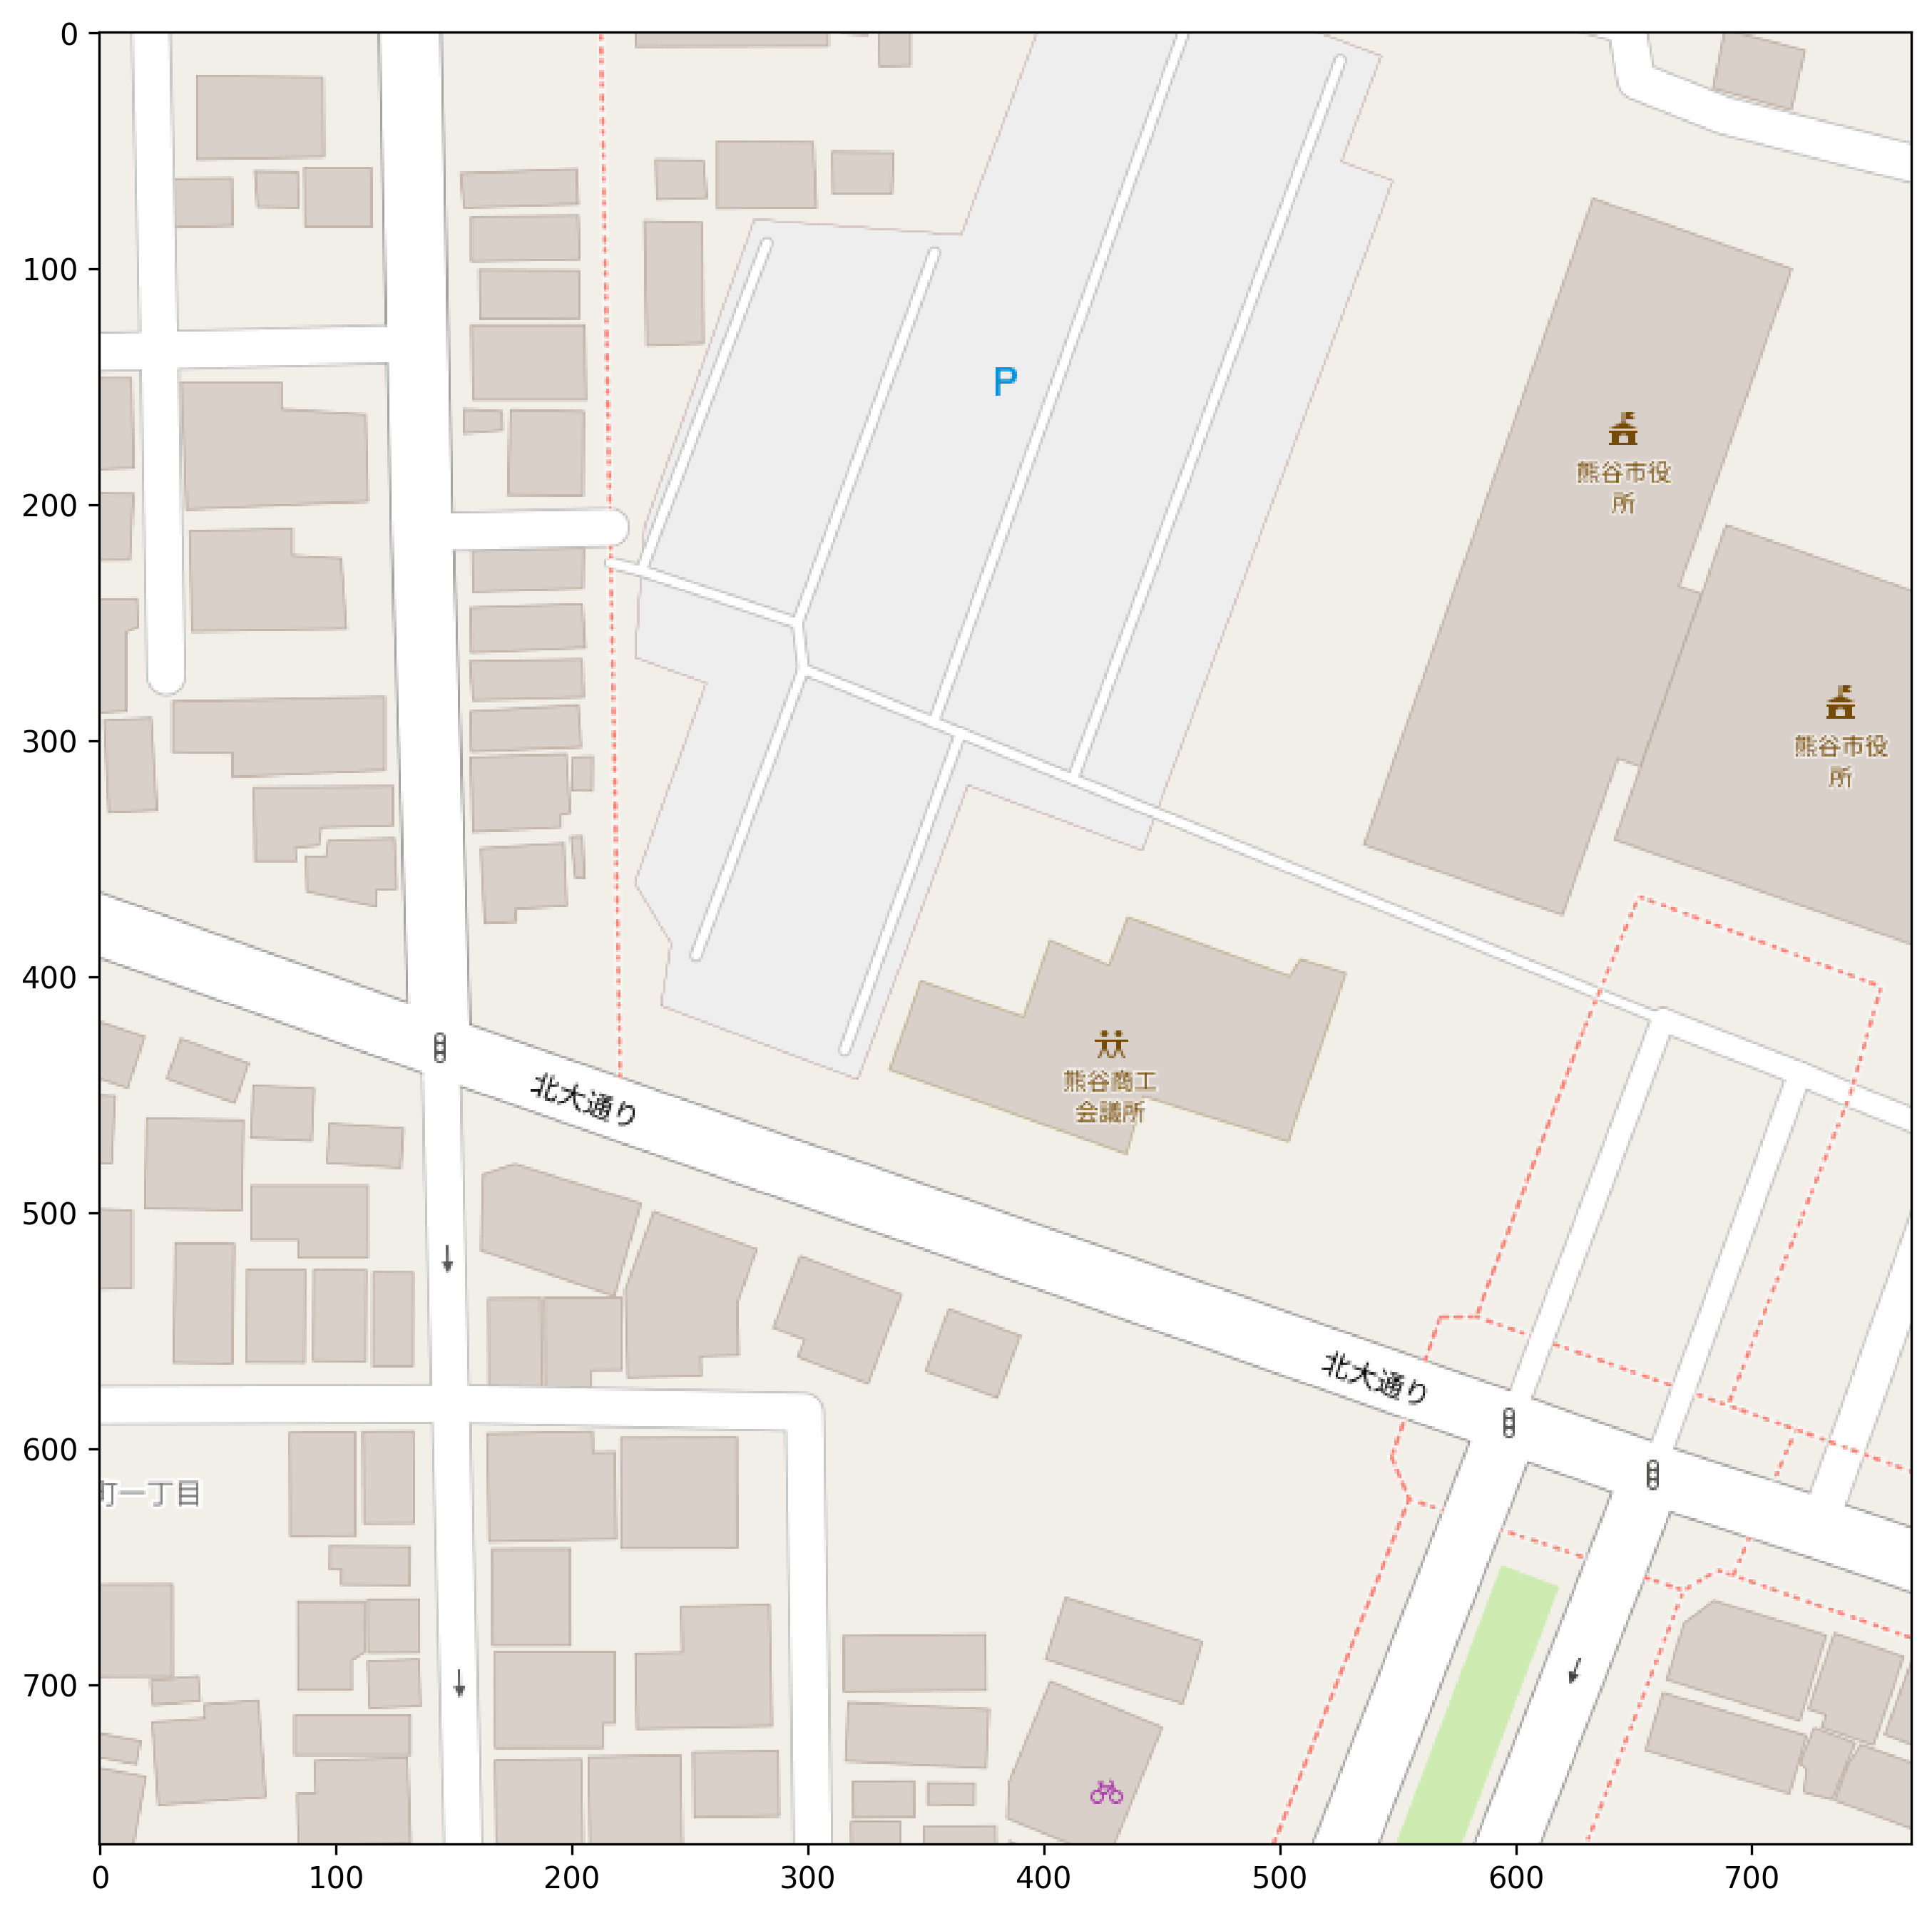

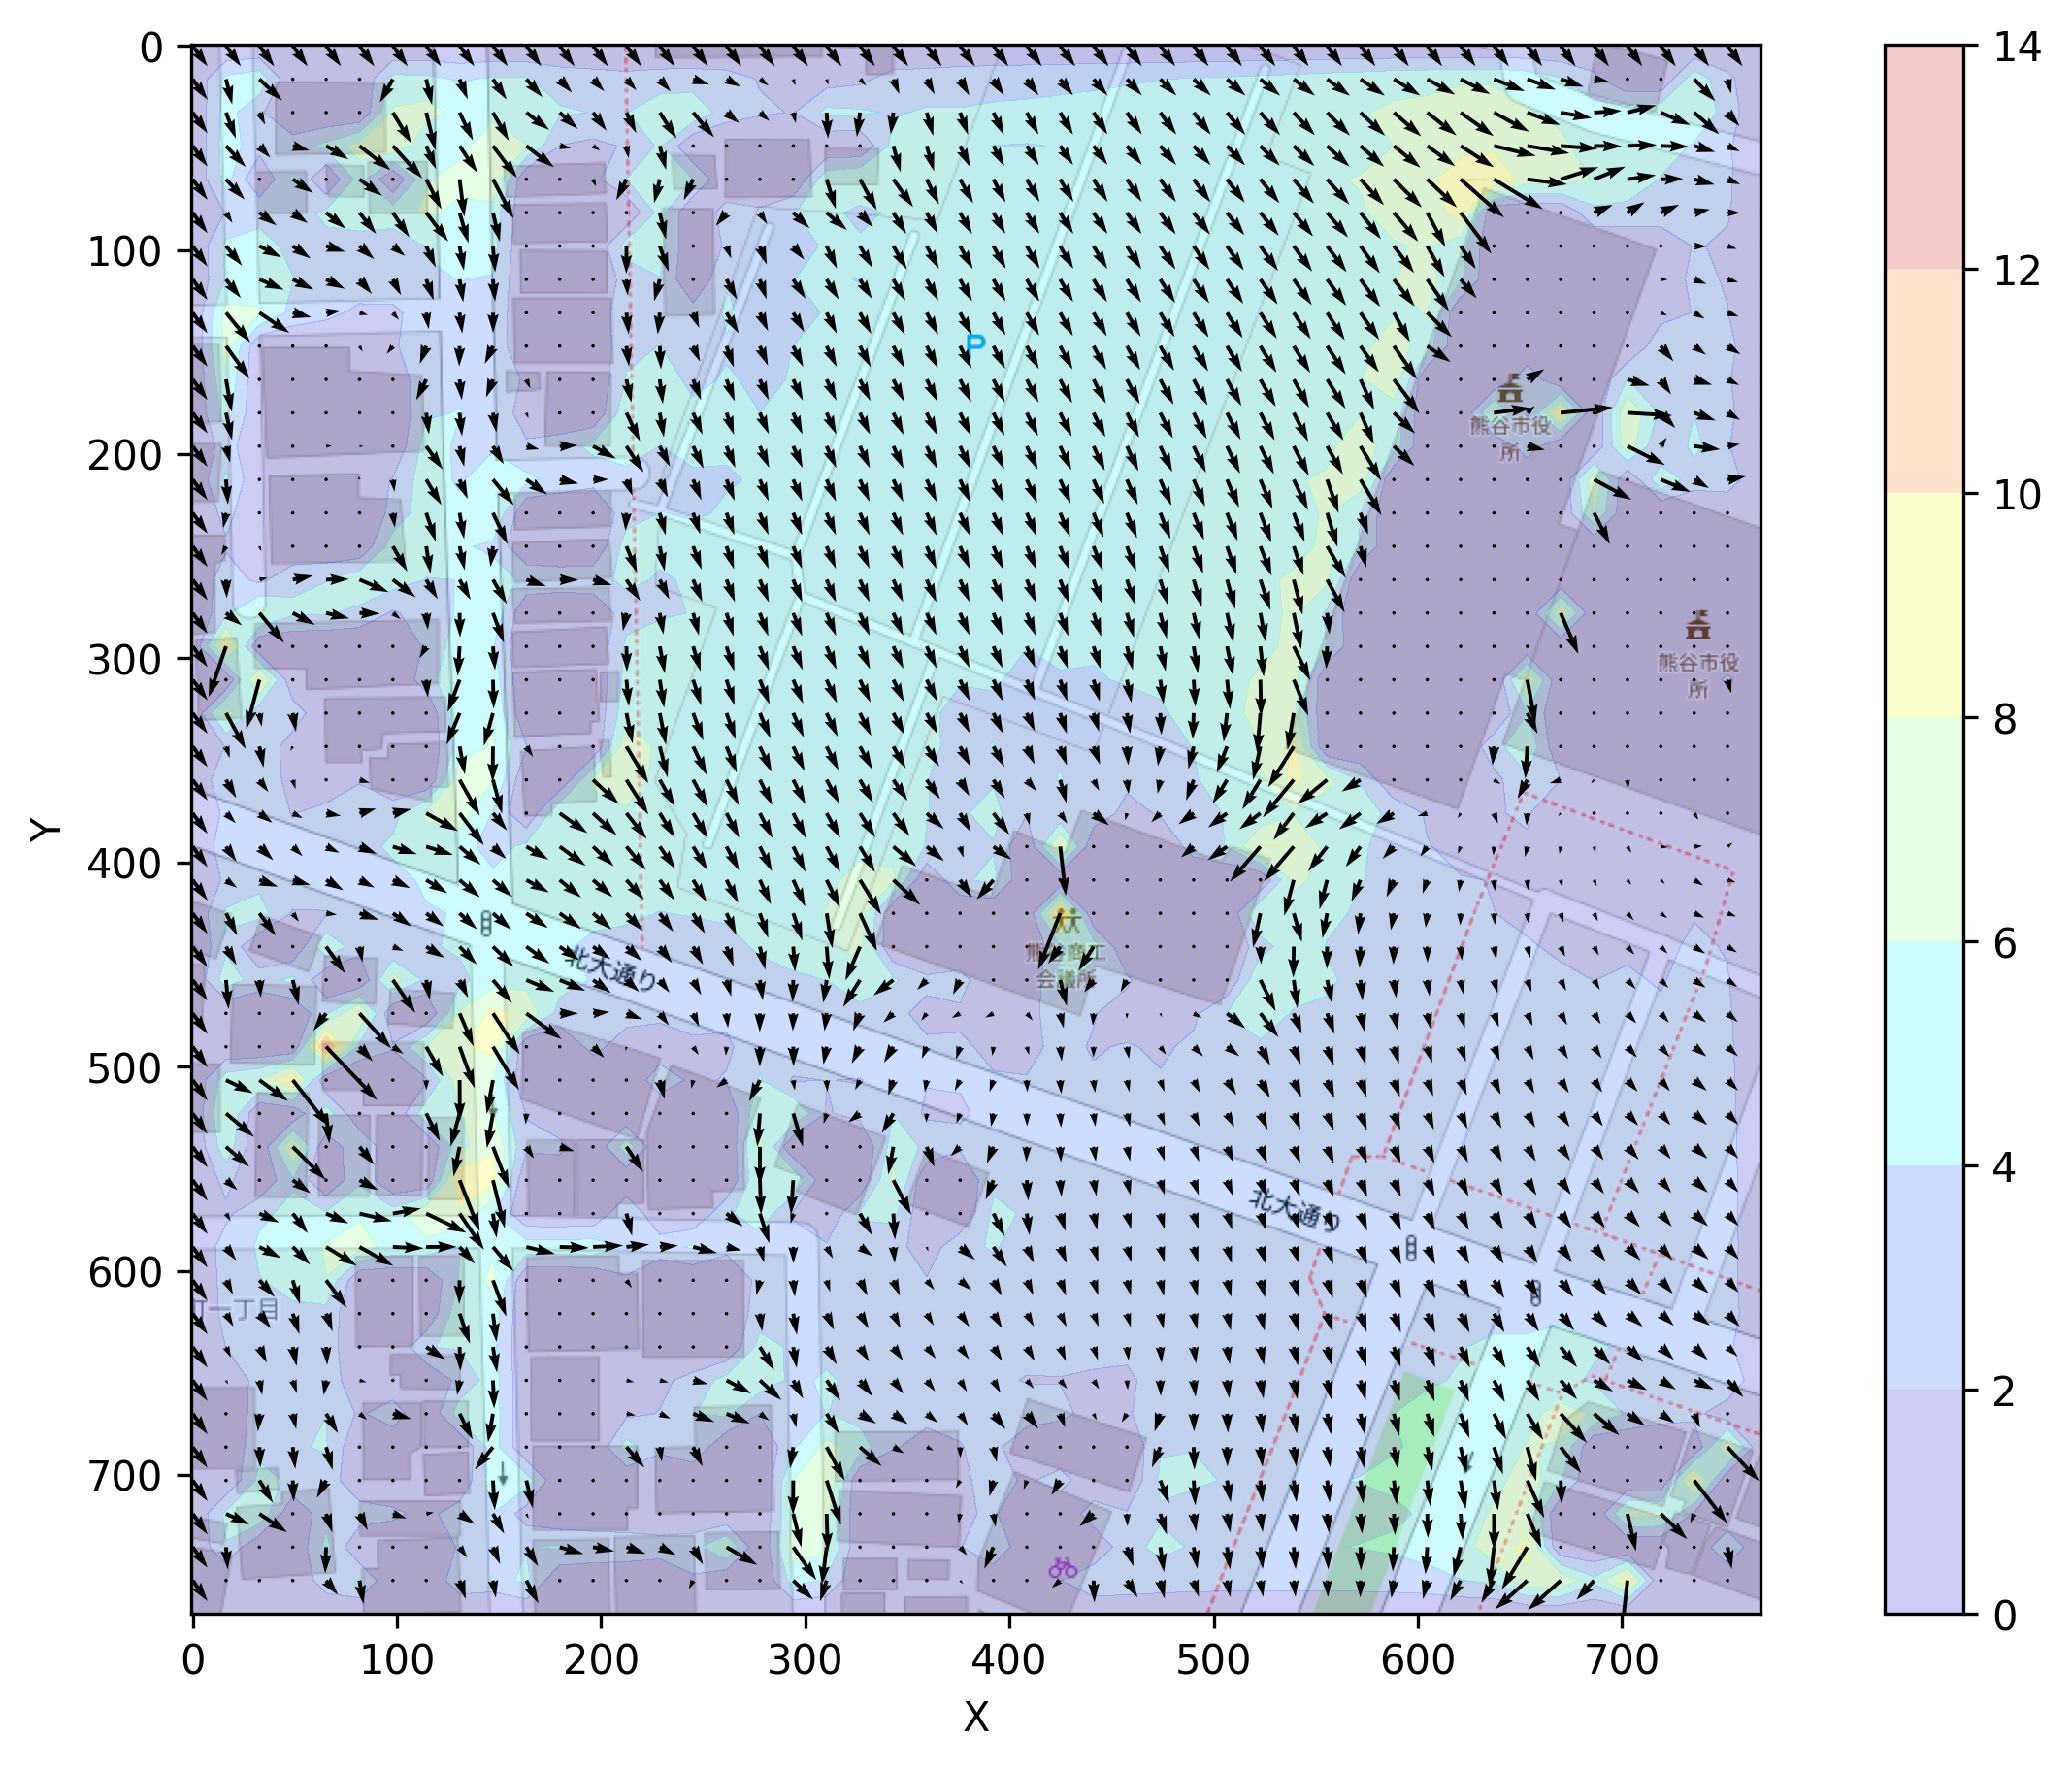

In [17]:
# 最初の画面のhtmlファイルを指定（会社のパソコン使用時：Chromeを使わない）
eel.start('index.html', options=web_app_options, suppress_error=True)